In [1]:
import numpy as np
from scipy.fftpack import fft, ifft
from scipy.signal import butter, lfilter
import scipy as sp
import matplotlib.pyplot as plt
from pylab import *

from time import perf_counter
import pandas as pd

%matplotlib qt

In [2]:
def thetagen(cycles,thetastepsize, forwardoffset):
    thetasingle = np.array(np.arange(0,720,thetastepsize))
    thetarel = np.tile(thetasingle,cycles)
    #thetacum = np.cumsum(thetarel)
    thetacum = np.array(np.arange(0,(720*cycles),thetastepsize))
    #thetacum = thetacum
    return thetasingle, thetarel, thetacum

In [3]:
def gasforcegen(gasforceraw, cycles, thetastepsize,forwardoffset,misfiring):
    thetasingle_deg, thetarel_deg, thetacum_deg = thetagen(cycles,thetastepsize,forwardoffset)
    gasforcerawdata = pd.read_csv(gasforceraw,sep=',',header=None)
    funcakimainterp_gf = sp.interpolate.Akima1DInterpolator(gasforcerawdata[0],gasforcerawdata[1])
    gasforce_theta_deg = funcakimainterp_gf(thetasingle_deg)
    gasforce_theta_deg_cycles = np.tile(gasforce_theta_deg,cycles)
    gasforce_theta_deg_cycles = gasforce_theta_deg_cycles*misfiring
    return gasforce_theta_deg_cycles, thetarel_deg,thetacum_deg

In [4]:
def torquegen(l1_m, l2_m,
              mrod, Izz, lg, mp, engine_speed_rpm, rp_m, 
              gasforcefile, cycles, thetastepsize,forwardoffset,misfiring):
    gasforce_theta_deg_cycles, thetarel_deg,thetacum_deg = gasforcegen(gasforcefile, cycles, thetastepsize,forwardoffset,misfiring)
    #gasforce_theta_deg_cycles = 35*gasforce_theta_deg_cycles/max(gasforce_theta_deg_cycles)
    thetacum_rad = thetacum_deg*np.pi/180
    theta_d = engine_speed_rpm*2*np.pi/60
    theta_dd = 0
    beta = np.arcsin(l1_m*np.sin(thetacum_rad)/l2_m)
    con1 = (1-(np.square(l1_m*np.sin(thetacum_rad)/l2_m)))
    beta_d = (theta_d*l1_m*np.cos(thetacum_rad))/(l2_m*np.sqrt(con1))
    
    a_beta_dd = l1_m*((theta_dd*np.cos(thetacum_rad))-((np.square(theta_d))*np.sin(thetacum_rad)))
    b_beta_dd = l2_m*np.sqrt(con1)
    c_beta_dd = np.square(theta_d)*np.power(l1_m,3)*np.square(np.cos(thetacum_rad))*np.sin(thetacum_rad)
    d_beta_dd = np.power(l2_m,3)*con1
    beta_dd= (a_beta_dd/b_beta_dd)+(c_beta_dd/d_beta_dd)

    a_vpis = (l1_m*theta_d*np.sin(thetacum_rad))
    b_vpis = (np.square(l1_m)*theta_d*np.sin(2*thetacum_rad))
    c_vpis = 2*l2_m*np.sqrt(con1)
    vpis = -a_vpis-(b_vpis/c_vpis)
    
    a_arx = l1_m*theta_dd*np.sin(thetacum_rad)
    b_arx = l1_m*(np.square(theta_d))*np.cos(thetacum_rad)
    c_arx = theta_dd*lg*np.square(l1_m)*np.sin(2*thetacum_rad)
    d_arx = 2*np.square(l2_m)*np.sqrt(con1)
    e_arx = np.square(l2_m)*(2*con1)
    f_arx = np.square(theta_d*l1_m)*lg
    g_arx = 2*np.cos(2*thetacum_rad)*np.sqrt(con1)
    h_arx = np.square(l1_m*np.sin(2*thetacum_rad))
    i_arx = 2*np.square(l2_m)*np.sqrt(con1)
    arx = -a_arx-b_arx-(c_arx/d_arx)-(1/e_arx)*f_arx*(g_arx+(h_arx/i_arx))
    
    a_ary = l1_m*theta_dd*np.cos(thetacum_rad)
    b_ary = l1_m*np.square(theta_d)*np.sin(thetacum_rad)
    c_ary = lg*l1_m*theta_dd*np.cos(thetacum_rad)/l2_m
    d_ary = lg*l1_m*theta_d*np.sin(thetacum_rad)/l2_m
    ary = a_ary - b_ary - c_ary+d_ary
    
    a_apx = l1_m*theta_dd*np.sin(thetacum_rad)
    b_apx = l1_m*(np.square(theta_d))*np.cos(thetacum_rad)
    c_apx = theta_dd*np.square(l1_m)*np.sin(2*thetacum_rad)
    d_apx = 2*l2_m*np.sqrt(con1)
    e_apx = l2_m*(2*con1)
    f_apx = np.square(theta_d*l1_m)
    g_apx = 2*np.cos(2*thetacum_rad)*np.sqrt(con1)
    h_apx = np.square(l1_m*np.sin(2*thetacum_rad))
    i_apx = 2*np.square(l2_m)*np.sqrt(con1)
    apx = -a_apx-b_apx-(c_apx/d_apx)-(1/e_apx)*f_apx*(g_apx+(h_apx/i_apx))
    
    fpx = (mp*apx)+((np.pi)*np.square(rp_m)*gasforce_theta_deg_cycles*0.1*1000000/4)
    
    fax = mrod*arx+fpx
    fay = (1/l2_m)*(((Izz*beta_dd-(fax*lg-fpx*(l2_m-lg)*np.sin(beta)))/np.cos(beta))+mrod*ary*(l2_m-lg))
    
    fx = fax*np.cos(thetacum_rad)+fay*np.sin(thetacum_rad)
    fy = fay*np.cos(thetacum_rad)-fax*np.sin(thetacum_rad)
    #forwardoffset = forwardoffset*np.pi/180
    #thetacum_rad = thetacum_rad
    rpm2radpersec = 6*sp.pi/180
    omega1_radpsec = engine_speed_rpm*rpm2radpersec
    time = thetacum_rad/omega1_radpsec
    torque = -fy*l1_m*1000/2
    forwardoffset_rad = forwardoffset*np.pi/180
    time_offset = forwardoffset_rad/omega1_radpsec
    offsetindex = (np.where(time == time_offset))
    torque = np.roll(torque,offsetindex[0][0])
    return torque, time

In [5]:
fy_1, time_1 = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(3000), float(0.080),
                 'gaspressures.dat', 20, 0.1,0,1)
fy_5, time_5 = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(3000), float(0.080),
                 'gaspressures.dat', 20, 0.1,90,1)
fy_4, time_4 = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(3000), float(0.080),
                 'gaspressures.dat', 20, 0.1,180,1)
fy_8, time_8 = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(3000), float(0.080),
                 'gaspressures.dat', 20, 0.1,270,1)
fy_6, time_6 = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(3000), float(0.080),
                 'gaspressures.dat', 20, 0.1,360,1)
fy_3, time_3 = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(3000), float(0.080),
                 'gaspressures.dat', 20, 0.1,450,1)
fy_7, time_7 = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(3000), float(0.080),
                 'gaspressures.dat', 20, 0.1,540,1)
fy_2, time_2 = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(3000), float(0.080),
                 'gaspressures.dat', 20, 0.1,630,1)

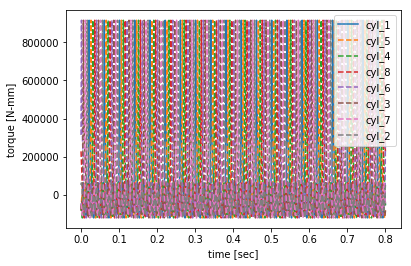

In [6]:
plt.plot(time_1,fy_1,label='cyl_1')
plt.plot(time_1,fy_5,"--",label='cyl_5')
plt.plot(time_1,fy_4,"--",label='cyl_4')
plt.plot(time_1,fy_8,"--",label='cyl_8')
plt.plot(time_1,fy_6,"--",label='cyl_6')
plt.plot(time_1,fy_3,"--",label='cyl_3')
plt.plot(time_1,fy_7,"--",label='cyl_7')
plt.plot(time_1,fy_2,"--",label='cyl_2')
plt.legend()
plt.xlabel("time [sec]")
plt.ylabel("torque [N-mm]")
plt.show()

In [7]:
torque = fy_1+fy_5+fy_4+fy_8+fy_6+fy_3+fy_7+fy_2

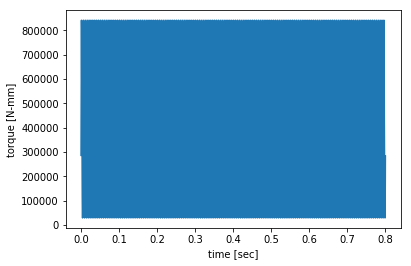

In [8]:
plt.plot(time_1,torque)
plt.xlabel("time [sec]")
plt.ylabel("torque [N-mm]")
plt.show()

In [9]:

#Vectorised Code#Vector 
def eval_freqfft_vect(time_sec, vibr):
    datalength_fft = len(time_sec)
    datalengthby2 = int(datalength_fft/2)
    timeavgcalc = np.array([], dtype = float64)
    time_sec_i = time_sec[1:]
    time_sec_i_1 = time_sec[:-1]
    timeavgcalc = time_sec_i - time_sec_i_1
    sigint_avg = np.mean(timeavgcalc)
    siginf = 1/(datalength_fft*sigint_avg)
    freqhztemp = np.arange(0,datalength_fft,dtype = float64)
    freqhz = freqhztemp*siginf
    freqhz = freqhz[0:datalengthby2]
    vibr_fft = np.abs(fft(vibr,axis = -1))
    vibr_fft = ((vibr_fft[0:datalengthby2])/datalength_fft)*2
    return freqhz,vibr_fft

In [10]:
fy_1_mf, time_1_mf = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(3000), float(0.080),
                 'gaspressures.dat', 20, 0.1,270,0.1)

fy_8_mf, time_8_mf = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(3000), float(0.080),
                 'gaspressures.dat', 20, 0.1,270,0.1)

In [11]:
torque_cyl1mf = fy_1_mf+fy_5+fy_4+fy_8   +fy_6+fy_3+fy_7+fy_2
torque_cyl8mf = fy_1   +fy_5+fy_4+fy_8_mf+fy_6+fy_3+fy_7+fy_2

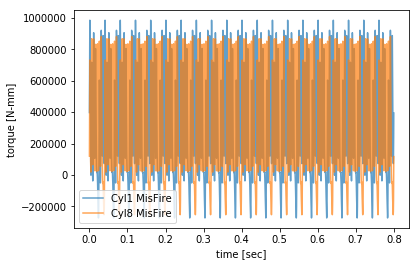

In [12]:
plt.plot(time_1,torque_cyl1mf, "-", label ="Cyl1 MisFire", alpha=0.7)
plt.plot(time_1,torque_cyl8mf, label ="Cyl8 MisFire", alpha=0.7)
plt.xlabel("time [sec]")
plt.ylabel("torque [N-mm]")
plt.legend()
plt.show()

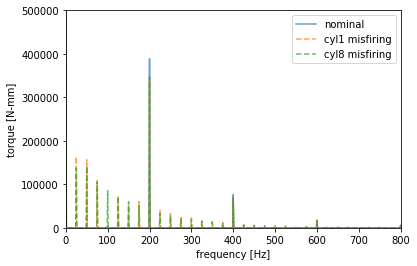

In [13]:
freq,vibr = eval_freqfft_vect(time_1,torque)
freq_cyl1mf,vibr_cyl1mf = eval_freqfft_vect(time_1,torque_cyl1mf)
freq_cyl8mf,vibr_cyl8mf = eval_freqfft_vect(time_1,torque_cyl8mf)
plt.plot(freq,vibr, label = "nominal", alpha=0.7)
plt.plot(freq_cyl1mf,vibr_cyl1mf, "--", label="cyl1 misfiring", alpha=0.7)
plt.plot(freq_cyl8mf,vibr_cyl8mf, "--", label="cyl8 misfiring", alpha=0.7)
plt.xlim(0,800) 
plt.ylim(0,500000) 
plt.legend()
plt.xlabel("frequency [Hz]")
plt.ylabel("torque [N-mm]")
plt.show()